(911, 1)
850
61
epoch:   1 loss: 0.25784376
epoch:  14 loss: 0.0008872585
[[ 479.00001273]
 [ 349.99999306]
 [1561.00000751]
 [1450.99999583]
 [1453.99998197]
 [1285.99999882]
 [1273.00000416]
 [ 453.99999142]
 [ 324.00000373]
 [1473.99999902]
 [1461.00000435]
 [1376.00001398]
 [1273.00000416]
 [1257.99999137]
 [ 526.99999619]
 [ 327.99999893]
 [1432.9999969 ]
 [1405.99999851]
 [1248.99999191]
 [1305.00000681]
 [1141.99999715]
 [ 525.0000191 ]
 [ 310.        ]
 [1470.00000381]
 [1589.00001496]
 [1372.00001878]
 [1296.00000735]
 [1233.99999964]
 [ 549.99999937]
 [ 354.99999732]
 [1289.00000548]]
[[ 553.04048982]
 [1241.20976621]
 [1230.79708159]
 [1403.21427071]
 [1418.03453794]
 [1349.62272313]
 [1140.09260134]
 [ 616.27526331]
 [ 444.47983786]
 [1353.64734101]
 [1491.67969793]
 [1308.34226871]
 [1315.43290254]
 [1135.52337084]
 [ 620.14295265]
 [ 435.69266042]
 [1308.08771124]
 [1453.83739021]
 [1269.21223593]
 [1237.37096748]
 [1131.61099134]
 [ 567.42300686]
 [ 443.36369184]
 [1237.

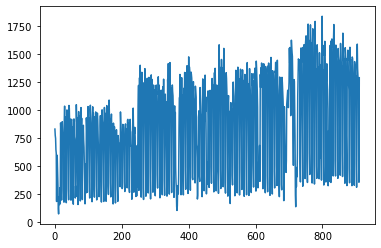

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class Mydataseries(Dataset):
    def __init__(self,input_data,tw):
        self.train_seq1 = []
        self.train_label1 = []
        self.L = len(input_data)
        print(self.L)
        for i in range(self.L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            self.train_seq1.append(train_seq)
            self.train_label1.append(train_label)
    def __len__(self):
        return len(self.train_seq1)
    def __getitem__(self,idx):
        return self.train_seq1[idx],self.train_label1[idx]

jiangda =pd.read_csv("datacount7part.csv", usecols=[1])
plt.plot(jiangda)
print(jiangda.shape)

jiangda2 = jiangda['y'].values.astype(float)
test_data_size = 61

train_data = jiangda2[:-test_data_size]
test_data = jiangda2[-test_data_size:]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
scaler = MinMaxScaler(feature_range=(-1, 1))
test_data_normalized = scaler.fit_transform(test_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
train_window = 30

mydataseries = Mydataseries(train_data_normalized,train_window)
mydataseriestest = Mydataseries(test_data_normalized,train_window)

trainseq1 = DataLoader(dataset=mydataseries, batch_size=1, shuffle=True, num_workers=0, drop_last=False)
testseq2 = DataLoader(dataset=mydataseriestest, batch_size=1,num_workers=0,drop_last=False)

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, batch_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        
    def forward(self, input_seq, hidden_cell):
        B, C = input_seq.shape
        input_seq = input_seq.reshape(B, C , -1)
        input_seq = input_seq.permute(1, 0 ,2)
        lstm_out, hidden_cell = self.lstm(input_seq, hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions[-1]
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15

for i in range(epochs):
    for train_seq,train_label in trainseq1:
        optimizer.zero_grad()
        hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                       torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(train_seq, hidden_cell)
        single_loss = loss_function(y_pred, train_label)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

model.eval()

pred = []
y = []
from itertools import chain
for (train_seq,train_label) in testseq2:
    train_label = list(chain.from_iterable(train_label.data.tolist()))
    y.extend(train_label)
    with torch.no_grad():
        hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                       torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(train_seq,hidden_cell)
        y_pred = list(chain.from_iterable(y_pred.data.tolist()))
        pred.extend(y_pred)
        
y, pred = np.array(y), np.array(pred)

actual_predictions = scaler.inverse_transform(y.reshape(-1, 1))
print(actual_predictions)
forecast_predictions = scaler.inverse_transform(pred.reshape(-1, 1))
print(forecast_predictions)

r_squared = r2_score(actual_predictions,forecast_predictions)
print(f"R方值：{r_squared}")

mae = mean_absolute_error(actual_predictions,forecast_predictions)
print(f"平均绝对误差（MAE）：{mae}")

rmse = np.sqrt(mean_squared_error(forecast_predictions,actual_predictions))
print(f"均方根误差（RMSE）：{rmse}")
forecast_predictions = np.squeeze(forecast_predictions)
test_dataact = jiangda2[-31:]
act = np.sum(test_dataact)
m  = np.abs(test_dataact - forecast_predictions)
gapsum = np.sum(m)
gap = gapsum/31
gapall = gapsum/act
print(gapsum,gap,gapall)